/sciclone/data10/iahewababarand/.venv/lib64/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1, Loss: 992.6821


Epoch 2, Loss: 576.4914


Epoch 3, Loss: 514.5408


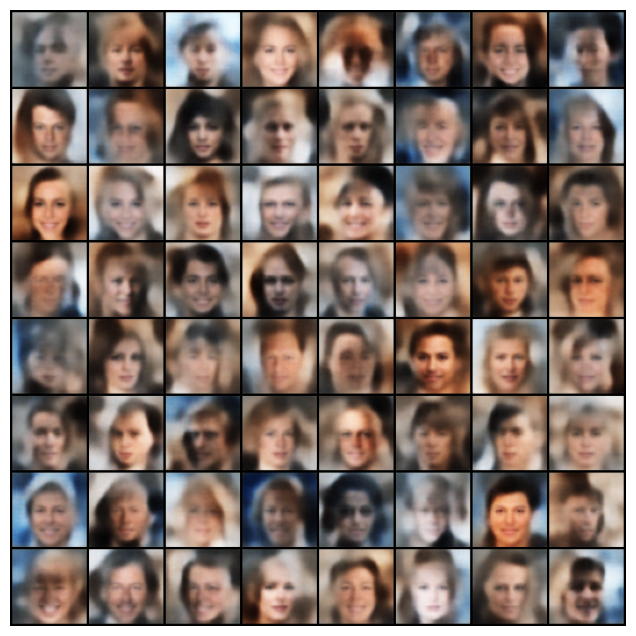

Generating 10,000 images...


Done! 10,000 images saved in: vae_outputs/generated


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import os

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset path
data_root = "celebA/celeba"
image_dir = os.path.join(data_root, "img_align_celeba")

transform = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(64),  # Changed to 64x64
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.ImageFolder(root=image_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

# Convolutional VAE for 64x64 images
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=100):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),   # 32x32
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # 8x8
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),# 4x4
            nn.ReLU(),
            nn.Conv2d(256, 512, 4, 2, 1),# 2x2
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(512 * 2 * 2, latent_dim)
        self.fc_logvar = nn.Linear(512 * 2 * 2, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, 512 * 2 * 2)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),  # 4x4
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),     # 64x64
            nn.Tanh()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        return self.fc_mu(x), self.fc_logvar(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(-1, 512, 2, 2)
        return self.decoder(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function
def loss_function(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + KLD

# Initialize model, optimizer, fixed noise
latent_dim = 128
model = ConvVAE(latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
fixed_z = torch.randn(64, latent_dim).to(device)
os.makedirs("vae_outputs", exist_ok=True)

# Training loop
epochs = 3
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_loss = train_loss / len(dataloader.dataset)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    # Save generated samples after each epoch
    model.eval()
    with torch.no_grad():
        generated = model.decode(fixed_z).cpu()
        generated = (generated + 1) / 2
        save_image(generated, f"vae_outputs/epoch_{epoch+1}.png", nrow=8)

# Final generation example
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    sample = model.decode(z).cpu()
    sample = (sample + 1) / 2
    plt.figure(figsize=(8, 8))
    plt.imshow(make_grid(sample, nrow=8).permute(1, 2, 0))
    plt.axis('off')
    plt.show()

# Generate 10,000 images at 64x64
output_dir = "vae_outputs/generated"
os.makedirs(output_dir, exist_ok=True)
total_images = 10000
batch_size = 100
model.eval()

print("Generating 10,000 images...")

with torch.no_grad():
    for i in range(0, total_images, batch_size):
        z = torch.randn(batch_size, latent_dim).to(device)
        samples = model.decode(z).cpu()
        samples = (samples + 1) / 2
        for j in range(samples.size(0)):
            idx = i + j
            filename = os.path.join(output_dir, f"img_{idx:05d}.png")
            save_image(samples[j], filename)

print("Done! 10,000 images saved in:", output_dir)
